In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy.highlevel import dmatrix
from statsmodels.tsa.seasonal import MSTL
import statsmodels.api as sm
d = pd.read_csv("../../data/old_data/cleaned_full_data.csv")

C:\Users\grube\AppData\Local\Temp\ipykernel_9444\3023367239.py:12: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv("../data/cleaned_full_data.csv")


Perform MSTL

In [87]:
# -----------------------------
# 1. Prepare data
# -----------------------------
df = d.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df[df["city"] == "Stadt Freiburg"]
df = df[df["counter_site_id"] == 100004595]
df = df.replace("na", np.nan)
df["count"] = pd.to_numeric(df["count"], errors="coerce")

# Time features
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek          # 0=Mon
df["doy"] = df["timestamp"].dt.dayofyear
df["year"] = df["timestamp"].dt.year

# Continuous time index for trend
df["t"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds() / (3600 * 24)

# Weather cleanup
numeric_cols = ["count", "site_temperature", "site_rain_accumulation", "hour", "dow", "doy", "t"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["rain"] = (df["site_rain_accumulation"] > 0).astype(int)

df = df.dropna(subset=["count", "site_temperature"]).copy()

# -----------------------------
# 2. MSTL decomposition
# -----------------------------
df_ts = df.copy()
df_ts = df_ts.set_index("timestamp")  # <- important!
mstl = MSTL(df_ts["count"], periods=[24, 24*7, 24*365])
mstl_result = mstl.fit()

Prepare GLM with splines for seasonalities

In [148]:
df_ts["trend"] = mstl_result.trend
df_ts["seasonal_hourly"] = mstl_result.seasonal.iloc[:,0]
df_ts["seasonal_weekly"] = mstl_result.seasonal.iloc[:,1]
df_ts["seasonal_yearly"] = mstl_result.seasonal.iloc[:,2]
df_ts["resid"] = mstl_result.resid

# -----------------------------
# 3. Regression setup
# -----------------------------
def build_regression_matrix(df_input):
    """Build regression matrix with splines and categorical variables"""
    # Trend spline
    trend_spline = dmatrix("bs(t, df=6)", data=df_input, return_type="dataframe")
    # Yearly seasonality
    year_spline = dmatrix("cc(doy, df=8, lower_bound=1, upper_bound=366)", data=df_input, return_type="dataframe")
    # Temperature spline
    temp_spline = dmatrix("bs(site_temperature, df=6)", data=df_input, return_type="dataframe")

    X = pd.concat([
        df_input[["rain", "hour", "dow"]],
        trend_spline.add_prefix("trend_"),
        year_spline.add_prefix("year_"),
        temp_spline.add_prefix("temp_")
    ], axis=1)

    # Categorical variables
    for c in ["hour", "dow"]:
        X[c] = X[c].astype("category")
    X = pd.get_dummies(X, columns=["hour", "dow"], drop_first=True)

    X = sm.add_constant(X)
    return X

# Full regression matrix
X_full = build_regression_matrix(df_ts)

y_full = df_ts["count"].astype(float)
cols_full = X_full.columns
# -----------------------------
# 4. Regression
# -----------------------------
def run_glm(y, X):
    model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
    result = model.fit(maxiter=100, method="lbfgs")
    return result


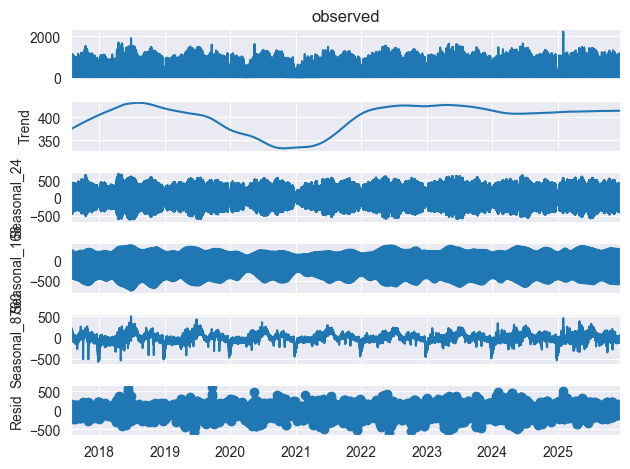

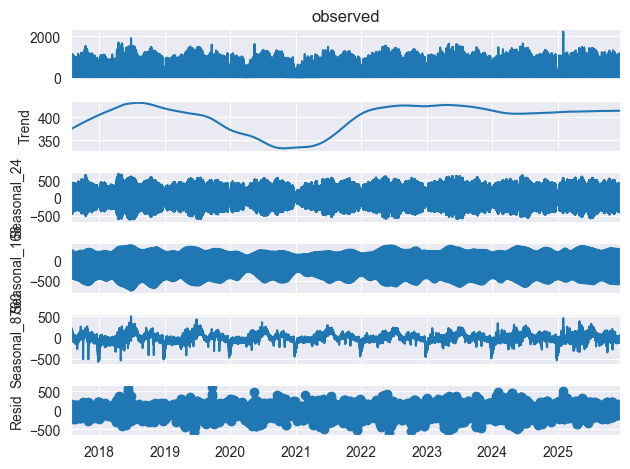

In [103]:
mstl_result.plot()

Fit GLM

In [108]:
# Regression on original data
y_full = df_ts["count"].to_numpy(dtype=float)
result_full = run_glm(y_full, X_full)


C:\Users\grube\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\grube\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


GLM on detrended data

In [110]:
# Regression on detrended data (trend removed via MSTL)
df_detrended = df_ts.copy()
df_detrended["count_detrended"] = df_ts["count"] - df_ts["trend"]
X_detrended = build_regression_matrix(df_detrended)
cols_det = X_detrended.columns
print(df_detrended)

                                     city counter_site_name  counter_site_id  \
timestamp                                                                      
2017-07-25 22:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2017-07-25 23:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2017-07-26 00:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2017-07-26 01:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2017-07-26 02:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
...                                   ...               ...              ...   
2025-12-12 18:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2025-12-12 19:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2025-12-12 20:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2025-12-12 21:00:00+00:00  Stadt Freiburg      Wiwilibrücke        100004595   
2025-12-12 22:00:00+00:00  Stadt Freibur

In [118]:
y_detrended = df_detrended["count_detrended"].to_numpy(dtype=float)
model = sm.GLM(y_detrended, X_detrended, family=sm.families.Gaussian())
result_detrended = model.fit()
print(mstl_result.trend)

timestamp
2017-07-25 22:00:00+00:00    373.567748
2017-07-25 23:00:00+00:00    373.576774
2017-07-26 00:00:00+00:00    373.585801
2017-07-26 01:00:00+00:00    373.594827
2017-07-26 02:00:00+00:00    373.603853
                                ...    
2025-12-12 18:00:00+00:00    413.978220
2025-12-12 19:00:00+00:00    413.978488
2025-12-12 20:00:00+00:00    413.978757
2025-12-12 21:00:00+00:00    413.979025
2025-12-12 22:00:00+00:00    413.979293
Name: trend, Length: 73480, dtype: float64


Plot model prediction vs observed vs detrended model prediction

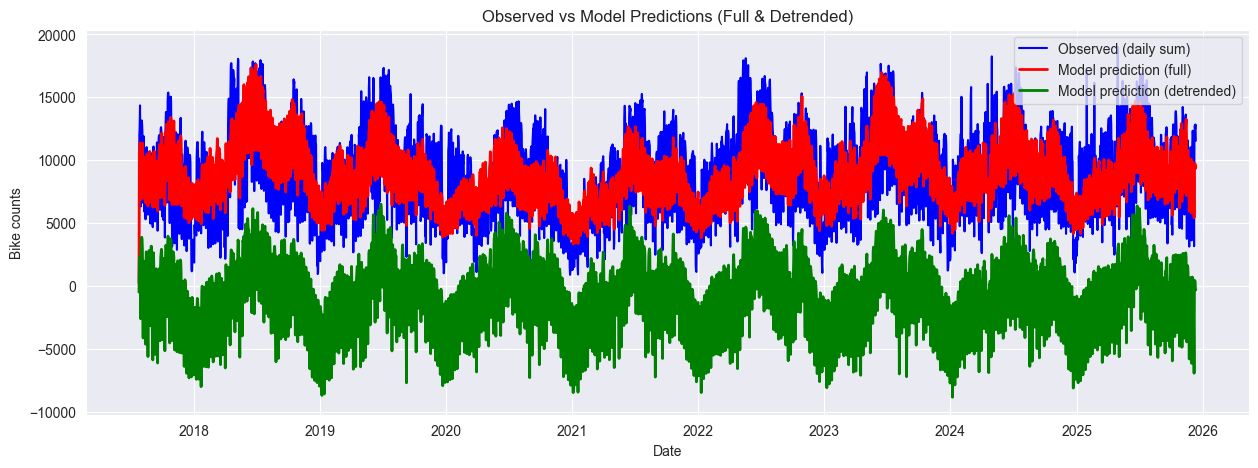

In [155]:
# Daily aggregation for smoother plotting
df_daily = df_ts["count"].resample("D").sum()
# Convert fittedvalues to Series with timestamp index
pred_full = pd.Series(result_full.fittedvalues, index=df_ts.index).resample("D").sum()
pred_detrended = pd.Series(result_detrended.fittedvalues, index=df_ts.index).resample("D").sum()

plt.figure(figsize=(15,5))
plt.plot(df_daily.index, df_daily, label="Observed (daily sum)", color="blue")
plt.plot(pred_full.index, pred_full, label="Model prediction (full)", color="red", linewidth=2)
plt.plot(pred_detrended.index, pred_detrended, label="Model prediction (detrended)", color="green", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Bike counts")
plt.title("Observed vs Model Predictions (Full & Detrended)")
plt.legend()
plt.grid(True)
plt.show()


Prediction of the GLM

C:\Users\grube\AppData\Local\Temp\ipykernel_9444\2110615808.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_hours = pd.date_range(start=df_ts.index.max() + pd.Timedelta(hours=1),
C:\Users\grube\AppData\Local\Temp\ipykernel_9444\2110615808.py:13: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  weather_last_year = df.set_index("timestamp")[["site_temperature", "rain"]].last("365D")


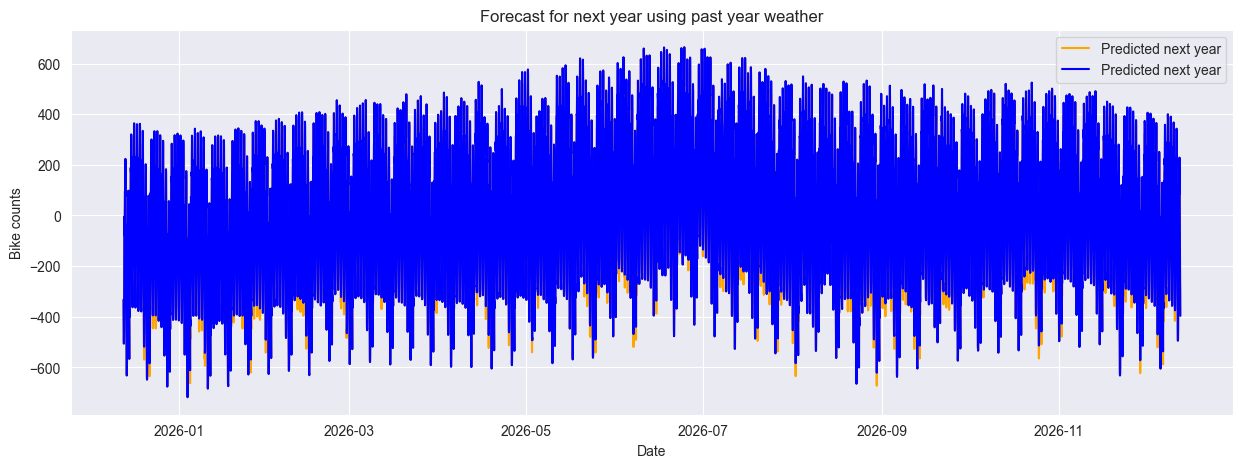

In [145]:
# Example: create a future dataframe for 1 full year hourly
future_hours = pd.date_range(start=df_ts.index.max() + pd.Timedelta(hours=1),
                             end=df_ts.index.max() + pd.Timedelta(days=365),
                             freq="H")
df_future = pd.DataFrame(index=future_hours)
df_future["timestamp"] = df_future.index
df_future["hour"] = df_future["timestamp"].dt.hour
df_future["dow"] = df_future["timestamp"].dt.dayofweek
df_future["doy"] = df_future["timestamp"].dt.dayofyear
df_future["t"] = (df_future["timestamp"] - df_ts.index.min()).dt.total_seconds() / (3600*24)

# Use past year's weather
weather_last_year = df.set_index("timestamp")[["site_temperature", "rain"]].last("365D")
n_repeats = int(np.ceil(len(df_future)/len(weather_last_year)))
weather_future = pd.concat([weather_last_year]*n_repeats).iloc[:len(df_future)]

df_future["site_temperature"] = weather_future["site_temperature"].values
df_future["rain"] = weather_future["rain"].values
X_future = build_regression_matrix(df_future)
y_future_pred = result_detrended.predict(X_future)  # returns array or Series
df_future["predicted_count"] = y_future_pred  # only apply exp if the model used log link
# Predict
df_future["rain"] = 0
X_future = build_regression_matrix(df_future)
y_future_pred = result_detrended.predict(X_future)  # returns array or Series
df_future["predicted_count_no"] = y_future_pred  # only apply exp if the model used log link
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_future.index, df_future["predicted_count"], label="Predicted next year", color="orange")
plt.plot(df_future.index, df_future["predicted_count_no"], label="Predicted next year", color="blue")
plt.xlabel("Date")
plt.ylabel("Bike counts")
plt.title("Forecast for next year using past year weather")
plt.legend()
plt.grid(True)
plt.show()


Temperature effect detrended vs not detrended

Rain effect (full model): -15.34%
Rain effect (detrended model): -12.81%


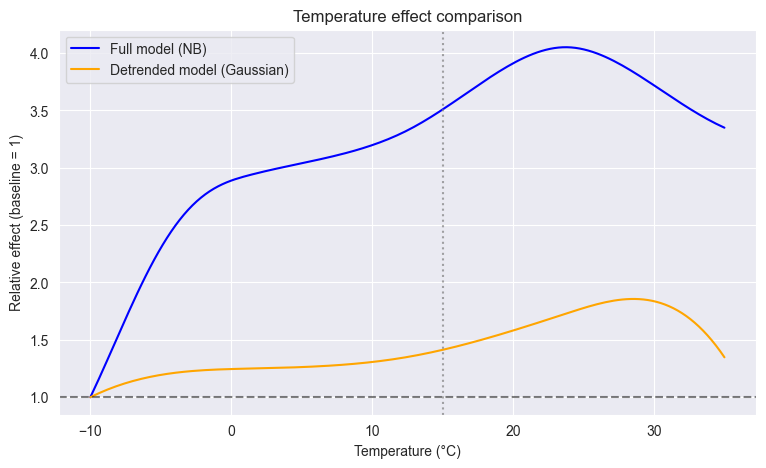

In [151]:
rain_idx_full = cols_full.get_loc("rain")

rain_effect_full = np.exp(result_full.params[rain_idx_full]) - 1
print(f"Rain effect (full model): {rain_effect_full:.2%}")

rain_idx_det = cols_det.get_loc("rain")

beta_rain_det = result_detrended.params[rain_idx_det]

# scale relative to mean count
mean_count = df["count"].mean()
rain_effect_det = beta_rain_det / mean_count

print(f"Rain effect (detrended model): {rain_effect_det:.2%}")

temp_grid = np.linspace(-10, 35, 150)
temp_ref = 15.0
mean_count = df["count"].mean()
temp_basis = dmatrix(
    "bs(temp, df=6)",
    {"temp": temp_grid},
    return_type="dataframe"
)

temp_basis_ref = dmatrix(
    "bs(temp, df=6)",
    {"temp": [temp_ref]},
    return_type="dataframe"
)
temp_cols_full = [i for i, c in enumerate(cols_full) if c.startswith("temp_")]

beta_full = result_full.params[temp_cols_full]

log_eff_full = temp_basis.values @ beta_full
log_eff_ref = temp_basis_ref.values @ beta_full

temp_effect_full = np.exp(log_eff_full - log_eff_ref)
temp_cols_det = [i for i, c in enumerate(cols_det) if c.startswith("temp_")]

beta_det = result_detrended.params[temp_cols_det]

eff_det = temp_basis.values @ beta_det
eff_ref_det = temp_basis_ref.values @ beta_det

temp_effect_det = 1 + (eff_det - eff_ref_det) / mean_count
plt.figure(figsize=(9,5))

plt.plot(temp_grid, temp_effect_full, label="Full model (NB)", color="blue")
plt.plot(temp_grid, temp_effect_det, label="Detrended model (Gaussian)", color="orange")

plt.axhline(1.0, color="black", linestyle="--", alpha=0.5)
plt.axvline(temp_ref, color="gray", linestyle=":", alpha=0.7)

plt.xlabel("Temperature (°C)")
plt.ylabel("Relative effect (baseline = 1)")
plt.title("Temperature effect comparison")
plt.legend()
plt.grid(True)
plt.show()


Yearly seasonality as captured by the GLM

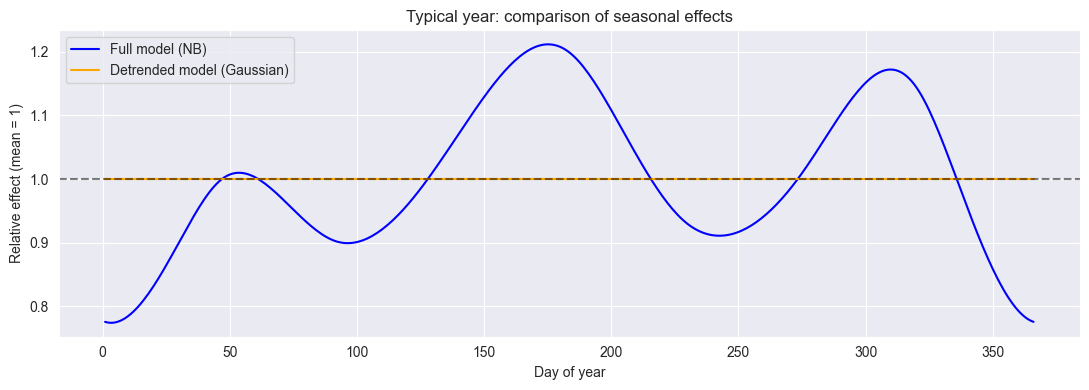

In [152]:
doy_grid = np.arange(1, 367)

year_basis = dmatrix(
    "cc(doy, df=8, lower_bound=1, upper_bound=366)",
    {"doy": doy_grid},
    return_type="dataframe"
)
year_cols_full = [i for i, c in enumerate(cols_full) if c.startswith("year_")]
beta_year_full = result_full.params[year_cols_full]

log_year_full = year_basis.values @ beta_year_full
year_effect_full = np.exp(log_year_full)

# Normalize (typical year)
year_effect_full /= year_effect_full.mean()
year_cols_det = [i for i, c in enumerate(cols_det) if c.startswith("year_")]
beta_year_det = result_detrended.params[year_cols_det]

year_effect_det_raw = year_basis.values @ beta_year_det

# Convert to relative effect
mean_count = df["count"].mean()
year_effect_det = 1 + year_effect_det_raw / mean_count

# Normalize (typical year)
year_effect_det /= year_effect_det.mean()
plt.figure(figsize=(11,4))

plt.plot(doy_grid, year_effect_full, label="Full model (NB)", color="blue")
plt.plot(doy_grid, year_effect_det, label="Detrended model (Gaussian)", color="orange")

plt.axhline(1.0, color="black", linestyle="--", alpha=0.5)

plt.xlabel("Day of year")
plt.ylabel("Relative effect (mean = 1)")
plt.title("Typical year: comparison of seasonal effects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Prepare and fit another GLM

In [12]:
df = d.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df[df["city"] == "Stadt Freiburg"]
df = df[df["counter_site_id"] == 100004595]

# Time features
df["hour"] = df["timestamp"].dt.hour
df["dow"] = df["timestamp"].dt.dayofweek          # 0=Mon
df["doy"] = df["timestamp"].dt.dayofyear
df["year"] = df["timestamp"].dt.year

# Continuous time index for trend
df["t"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds() / (3600 * 24)

numeric_cols = [
    "count",
    "site_temperature",
    "site_rain_accumulation",
    "hour",
    "dow",
    "doy",
    "t",
]
# Weather cleanup
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Rain indicator (often more stable than raw mm)
df["rain"] = (df["site_rain_accumulation"] > 0).astype(int)

# Drop rows with missing essentials
df = df.dropna(subset=["count", "site_temperature"])
# Cyclic yearly seasonality (day of year)
yearly_spline = dmatrix(
    "cc(doy, df=8,lower_bound=1, upper_bound=366)",
    data=df,
    return_type="dataframe"
)

# Long-term trend (slow)
trend_spline = dmatrix(
    "bs(t, df=6)",
    data=df,
    return_type="dataframe"
)

# Temperature nonlinearity
temp_spline = dmatrix(
    "bs(site_temperature, df=6)",
    data=df,
    return_type="dataframe"
)
X = pd.concat(
    [
        df[[
            "count",
            "hour",
            "dow",
            "rain",
            "city",
            "counter_site_id"
        ]],
        yearly_spline.add_prefix("year_"),
        trend_spline.add_prefix("trend_"),
        temp_spline.add_prefix("temp_"),
    ],
    axis=1
)
X["hour"] = X["hour"].astype("category")
X["dow"] = X["dow"].astype("category")
X["city"] = X["city"].astype("category")
X["counter_site_id"] = X["counter_site_id"].astype("category")


y = X["count"].astype(float)

X_model = X.drop(columns="count")

X_model = pd.get_dummies(
    X_model,
    columns=["hour", "dow", "city", "counter_site_id"],
    drop_first=True
)

X_model = sm.add_constant(X_model)

y_np = df["count"].to_numpy(dtype=float)
X_np = X_model.to_numpy(dtype=float)
model = sm.GLM(
    y_np,
    X_np,
    family=sm.families.NegativeBinomial()
)

result = model.fit(method="lbfgs", maxiter=100)


C:\Users\grube\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\grube\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Plot temperature curve

Rain effect multiplier: -0.15337765673367543
7.2146618586031


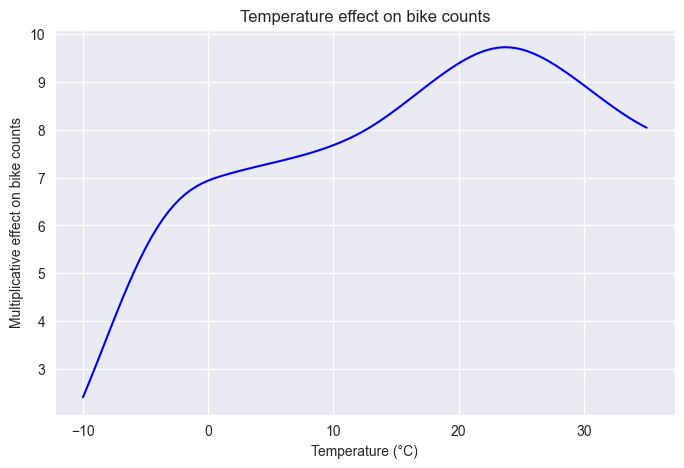

In [115]:
cols = X_model.columns

rain_idx = cols.get_loc("rain")  # integer position
rain_effect = np.exp(result.params[rain_idx]) - 1
print("Rain effect multiplier:", rain_effect)

# --------------------------
# 4. Temperature effect
# --------------------------
temp_cols_idx = [i for i, c in enumerate(cols) if c.startswith("temp_")]

# Create temperature grid and basis
temp_grid = np.linspace(-10, 35, 100)
temp_basis = dmatrix(
    "bs(temp, df=6)",
    {"temp": temp_grid},
    return_type="dataframe"
)

# Compute temperature effect
beta_temp = result.params[temp_cols_idx]
temp_effect = temp_basis.values @ beta_temp
temp_multiplier = np.exp(temp_effect)
print(temp_multiplier[30])

plt.figure(figsize=(8,5))
plt.plot(temp_grid, temp_multiplier, color="blue")
plt.xlabel("Temperature (°C)")
plt.ylabel("Multiplicative effect on bike counts")
plt.title("Temperature effect on bike counts")
plt.grid(True)
plt.show()

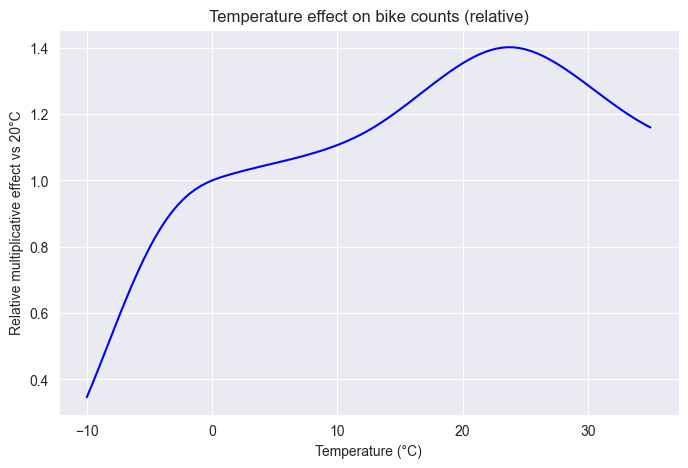

In [40]:
# Find index of reference temperature
ref_temp = 0
ref_idx = (np.abs(temp_grid - ref_temp)).argmin()

# Relative effect vs baseline
temp_relative = temp_multiplier / temp_multiplier[ref_idx]

plt.figure(figsize=(8,5))
plt.plot(temp_grid, temp_relative, color="blue")
plt.xlabel("Temperature (°C)")
plt.ylabel("Relative multiplicative effect vs 20°C")
plt.title("Temperature effect on bike counts (relative)")
plt.grid(True)
plt.show()


Effect of rain

In [42]:
rain_effect = np.exp(result.params[rain_idx]) - 1
print(rain_effect)

-0.15332744914262686


Plot yearly component as identified by the GLM

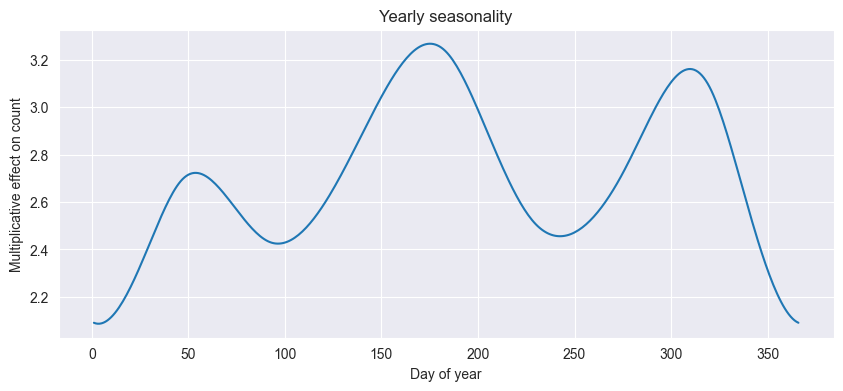

In [49]:
# Yearly grid
doy_grid = np.arange(1, 367)
year_basis = dmatrix(
    "cc(doy, df=8, lower_bound=1, upper_bound=366)",
    {"doy": doy_grid},
    return_type="dataframe"
)

# Find the indices of the yearly spline columns in X_model
year_cols_idx = [i for i, c in enumerate(X_model.columns) if c.startswith("year_")]

# Extract the coefficients using these indices
beta_year = result.params[year_cols_idx]

# Compute effect
year_log_effect = year_basis.values @ beta_year
year_multiplier = np.exp(year_log_effect)

# Plot
plt.figure(figsize=(10,4))
plt.plot(doy_grid, year_multiplier)
plt.xlabel("Day of year")
plt.ylabel("Multiplicative effect on count")
plt.title("Yearly seasonality")
plt.grid(True)
plt.show()


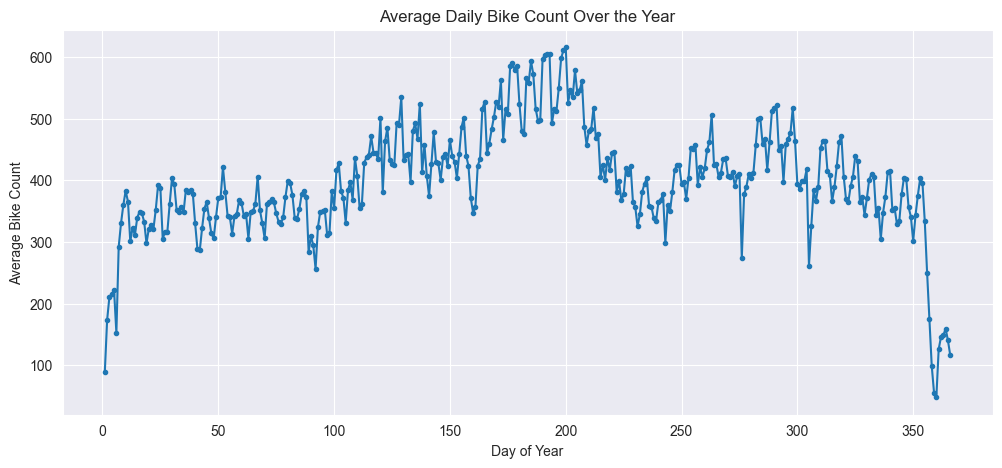

In [50]:
df["doy"] = df["timestamp"].dt.dayofyear

# Group by day of year and take the mean count
avg_year = df.groupby("doy")["count"].mean()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(avg_year.index, avg_year.values, marker=".", linestyle="-")
plt.xlabel("Day of Year")
plt.ylabel("Average Bike Count")
plt.title("Average Daily Bike Count Over the Year")
plt.grid(True)
plt.show()

Plot trend as identified by the GLM

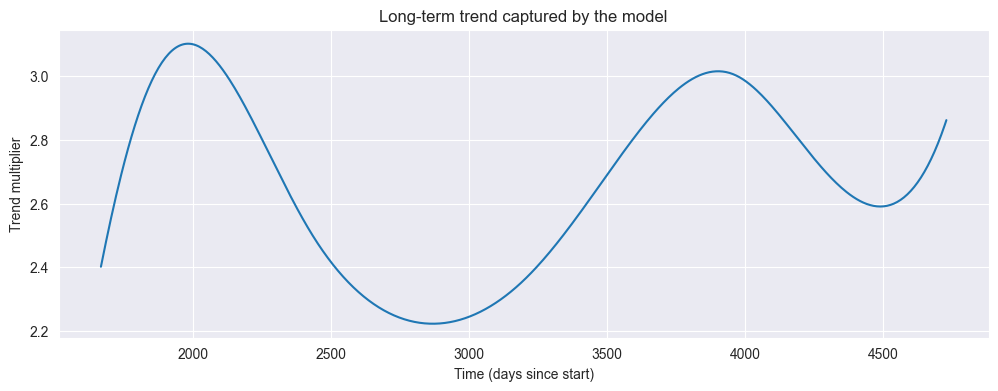

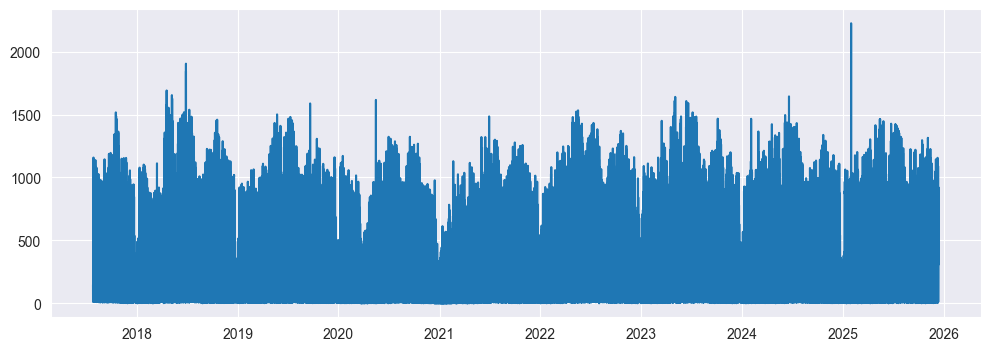

In [57]:
trend_spline = dmatrix("bs(t, df=6)", data=df, return_type="dataframe")
trend_cols_idx = [i for i, c in enumerate(X_model.columns) if c.startswith("trend_")]
beta_trend = result.params[trend_cols_idx]
# Time grid (in the same units as t)
t_grid = np.linspace(df["t"].min(), df["t"].max(), 500)
trend_basis = dmatrix("bs(t, df=6)", {"t": t_grid}, return_type="dataframe")
trend_log_effect = trend_basis.values @ beta_trend
trend_multiplier = np.exp(trend_log_effect)  # multiplicative effect
plt.figure(figsize=(12,4))
plt.plot(t_grid, trend_multiplier)
plt.xlabel("Time (days since start)")
plt.ylabel("Trend multiplier")
plt.title("Long-term trend captured by the model")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["count"])
plt.show()


Plot GLM results summary

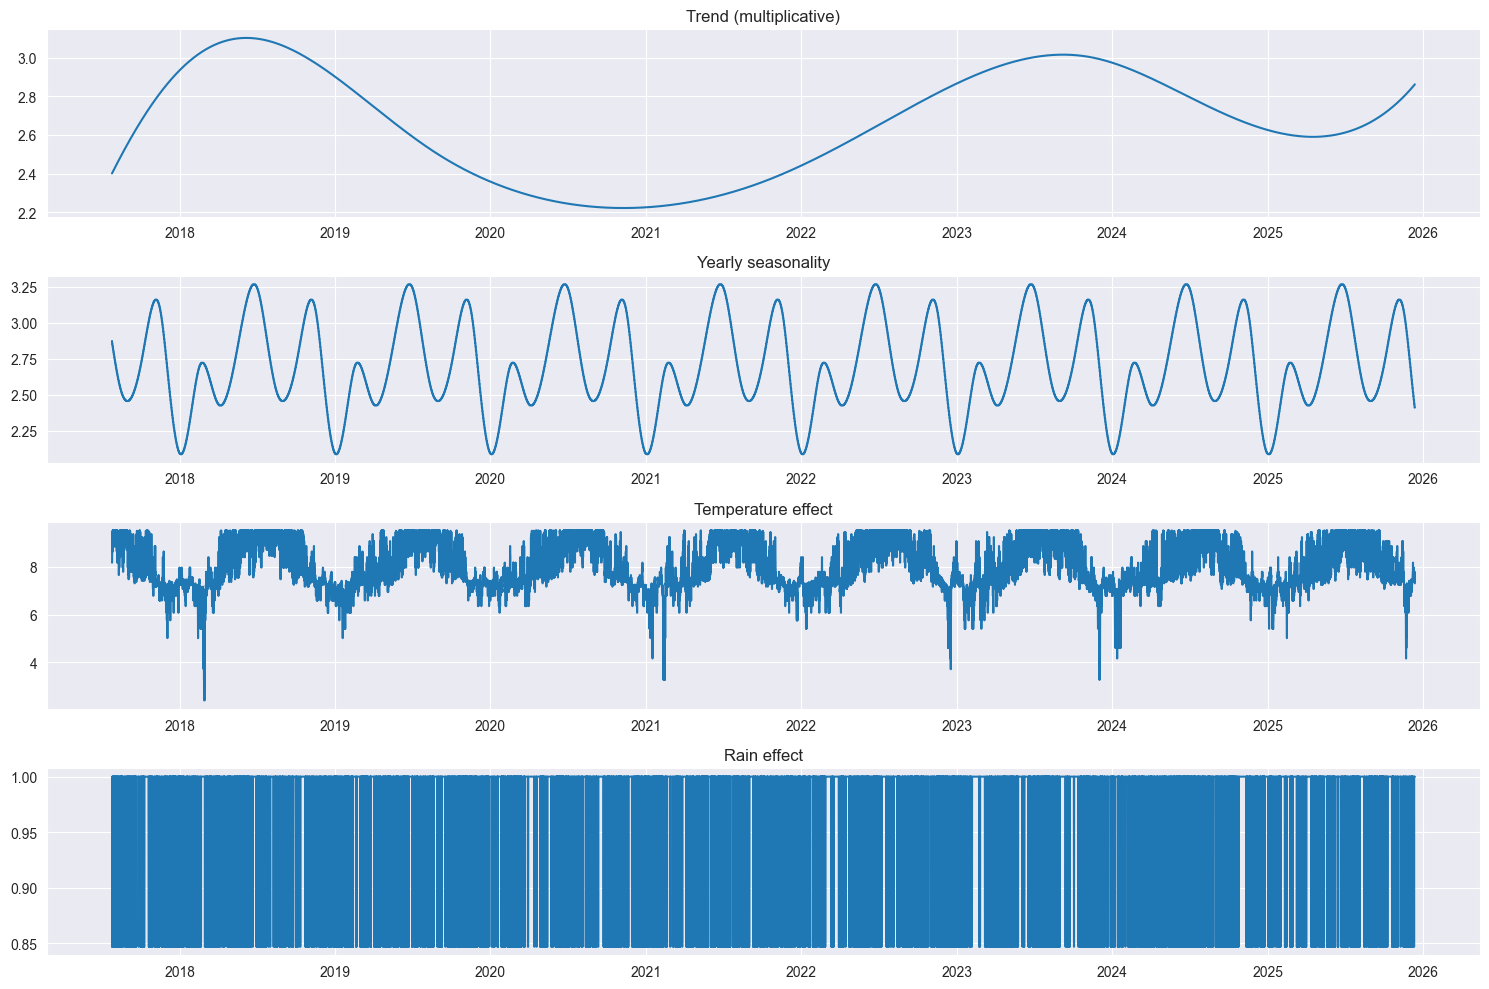

In [55]:
plt.figure(figsize=(15,10))

plt.subplot(4,1,1)
plt.plot(df["timestamp"], trend_multiplier)
plt.title("Trend (multiplicative)")

plt.subplot(4,1,2)
plt.plot(df["timestamp"], year_multiplier)
plt.title("Yearly seasonality")

plt.subplot(4,1,3)
plt.plot(df["timestamp"], temp_multiplier)
plt.title("Temperature effect")

plt.subplot(4,1,4)
plt.plot(df["timestamp"], rain_effect)
plt.title("Rain effect")

plt.tight_layout()
plt.show()
